In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
import random
import csv
import math
import numpy as np
import sys

## K-means Clustering non-distributed implementation 

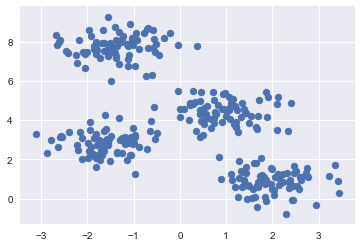

In [2]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
# Save simulated data to be used in MapReduce code
np.savetxt("kmeans_simulated_data.txt", X, fmt='%.18e', delimiter=' ')
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
# Write modules for the simulation of local K-Meanss
def assign_clusters(X, m):
    clusters  = {}
    labels = []
    for x in X:
        #Calculate pair wise distance from each centroid
        pair_dist = [(i[0], np.linalg.norm(x-m[i[0]])) for i in enumerate(m)]
        #Sort and select the minimum distance centroid
        best_centroid = min(pair_dist, key=lambda t:t[1])[0]
        labels.append(best_centroid)
        try:
            clusters[best_centroid].append(x)
        except KeyError:
            clusters[best_centroid] = [x]
    return(clusters, labels)

def evaluate_cluster_mean(clusters):
    new_centroid = []
    keys = sorted(clusters.keys())
    for k in keys:
        #Calculate new centroid
        new_centroid.append(np.mean(clusters[k], axis = 0))
    return(new_centroid)
 
def check_convergence(new_centroid, old_centroid):
    #Check if new and old centroid have changed or not
    error = np.all(np.array(new_centroid) == np.array(old_centroid))
    return(error)

def driver_kmeans(X, K):
    # Initialize Random K centres
    old_centroid = random.sample(list(X), K)
    new_centroid = random.sample(list(X), K)
    #Saving centroid co-ordinates for the comparison with MapReduce code
    np.savetxt("kmeans_cache.txt", new_centroid, fmt='%.18e', delimiter=' ')
    counter = 0
    while not check_convergence(new_centroid, old_centroid):
        old_centroid = new_centroid
        #Map points to nearest centroid
        clusters, labels = assign_clusters(X, new_centroid)
        # Find new centroids
        new_centroid = evaluate_cluster_mean(clusters)
        counter += 1
    return(new_centroid, clusters, labels, counter)

#Driver code intialize the mapreduce code
#Not used in the current implementation, added for completion
def init_kmeans(X, K):
    centroid = random.sample(list(X), K)
    init_centroid = np.array([np.concatenate(([i[0]], i[1])) for i in enumerate(centroid)])
    np.savetxt("kmeans_cache.txt", init_centroid, fmt='%.18e', delimiter=' ')

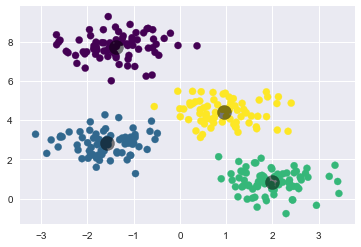

In [4]:
centers, d, labels, counter = driver_kmeans(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
cx = [i[0] for i in centers]
cy = [i[1] for i in centers]
plt.scatter(cx, cy, c='black', s=200, alpha=0.5);

## Simulating MapReduce K-Means Algorithm

#### Mapper Script
+ Assumes mapper data input in tidy format and all varibales are properly encoded

In [5]:
%%writefile mapper_kmeans.py

import sys
import csv
import math
import numpy as np

#Read the centroids iteratively and its co-ordinates
with open('kmeans_cache.txt', 'r') as f:
    fp = csv.reader(f, delimiter = " ")
    m = np.array([[float(i) for i in j] for j in fp])
        
        
# input comes from STDIN (standard input)
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip().split()
    features = np.array([float(j) for j in line])
    # Calculate the pair wise distance
    pair_dist = [(i[0], np.linalg.norm(features - m[i[0]])) for i in enumerate(m)]
    #Sort and select the minimum distance centroid
    best_centroid = min(pair_dist, key=lambda t:t[1])[0]
    #emit cluster id and coressponding values
    out_features = ",".join([str(k) for k in features])
    print('{}\t{}'.format(best_centroid, out_features))

Overwriting mapper_kmeans.py


#### Reducer Script

In [6]:
%%writefile reducer_kmeans.py
from operator import itemgetter
import sys
import numpy as np

current_cluster = None
current_val = 0

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    cluster, value = line.split('\t', 1)
    #Convert value to float
    try:
        value = [float(i) for i in value.split(',')]
    except ValueError:
        #Accounts for error in value inputs. Skips the error lines
        continue
    
    #Cluster id as key and corresponding value is passed here
    if current_cluster == cluster:
        current_val = np.vstack((current_val, value))
    else:
        if current_cluster:
            #Updates the centroids
            center = [str(i) for i in np.mean(current_val, axis = 0)]
            print('{}'.format(" ".join(center)))
                
        current_val = value
        current_cluster= cluster

# To print the last line/clutster id
if current_cluster == cluster:
    #Updates the centroids
    center = [str(i) for i in np.mean(current_val, axis = 0)]
    print('{}'.format(" ".join(center)))

Overwriting reducer_kmeans.py


#### Simulate Job Chaining with Shell Script
+ for loop iterates over each reducer output . 
+ Inside for loop Centroid co-ordinates are updated in __kmeans_cache.txt__ at each iteration . 
+ Final output is stored in _kmeans_cache.txt_  

In [12]:
%%sh
#Initialize the initial clusters
for i in `seq 1 20`;
do 
echo 'Iteration Number = '$i
cat kmeans_simulated_data.txt | python mapper_kmeans.py | sort | python reducer_kmeans.py > kmeans_temp.txt
mv kmeans_temp.txt kmeans_cache.txt
done

Iteration Number = 1
Iteration Number = 2
Iteration Number = 3
Iteration Number = 4
Iteration Number = 5
Iteration Number = 6
Iteration Number = 7
Iteration Number = 8
Iteration Number = 9
Iteration Number = 10
Iteration Number = 11
Iteration Number = 12
Iteration Number = 13
Iteration Number = 14
Iteration Number = 15
Iteration Number = 16
Iteration Number = 17
Iteration Number = 18
Iteration Number = 19
Iteration Number = 20


#### Test MapReduce Implementation

In [13]:
#Check if the centroid calculated in the non-distributed and distributed method are in same range
def check_mapreduce(centroid_non, centroid_dist):
    #Check if new and old centroid have changed or not
    error = np.all(np.array(centroid_non) == np.array(centroid_dist))
    #error calculation second way: Relative Error
    num_error = np.linalg.norm(np.array(centroid_non) - np.array(centroid_dist))
    return(error, num_error)

#Read the final centroid file
with open('kmeans_cache.txt', 'r') as f:
    fp = csv.reader(f, delimiter = " ")
    centroid_map = np.array([[float(i) for i in j] for j in fp])

flag, relative_error = check_mapreduce(centers, centroid_map)

if flag:
    print("Test Succeded: Both MapReduce and local algorithm returns the same centroids")
elif relative_error < 1e-6:
    msg = "Test Succeded: Both MapReduce and local algorithm returns the same centroids with tolerance = "
    print('{}\t{}'.format(msg, relative_error))
else:
    errmsg = '''Check MapReduce code, perhaps check if both
    Mapreduce and Local are initalized from same centroids
    Rerun both the codes multiple time to verify'''
    print(errmsg)

Test Succeded: Both MapReduce and local algorithm returns the same centroids with tolerance = 	2.3208707134311084e-15


#### Next Steps

+ Creating output for labeled data for further analysis in reducer 
+ Creating output for parameters for the model validation like cost value for selecting optimal k 

## References
1. Kumar, S., Dr. (2018, May 03). Shailesh Kumar - MapReduce and the "Art of Thinking Parallel". Retrieved May 6, 2018, from https://vimeo.com/72168757  
2. Kumar, S., Dr. (2018, May 03). Https://www.slideshare.net/hyderabadscalability/map-reduce-and-the-art-of-thinking-parallel-dr-shailesh-kumar. Retrieved May 6, 2018, from https://vimeo.com/72168757  
3. Leskovec, J., Rajaraman, A., & Ullman, J. D. (2016). Mining of massive datasets. Delhi: Cambridge University Press.  
4. Guttag, J. (2017). Introduction to computation and programming using Python: With application to understanding data. Cambridge, MA: The MIT Press.  
5. VanderPlas, Jake. “In Depth: k-Means Clustering.” Https://Jakevdp.github.io/PythonDataScienceHandbook/05.11-k-Means.html, 9 May 2018, jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html.    